In [1]:
import os
import pandas as pd
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader
import tqdm
import clip
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score
# from sklearn.manifold import TSNE
import umap
from sklearn.metrics import f1_score

/gpfs/home/zli288/my_cool_science/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/home/zli288/my_cool_science/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/home/zli288/my_cool_science/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be 

In [2]:
tif_files = []
for dirpath, _, filenames in os.walk("CRC-VAL-HE-7K"):
    for filename in [f for f in filenames if f.endswith('.tif')]:
        tif_files.append(os.path.join(dirpath, filename))

image_arrays = [imread(tif_file) for tif_file in tif_files]
all_images = np.stack(image_arrays)
print(all_images.shape)

(7180, 224, 224, 3)


In [3]:
all_images = all_images/255.0 

In [4]:
all_images[0]

array([[[0.89411765, 0.79607843, 0.86666667],
        [0.87843137, 0.76862745, 0.90196078],
        [0.90196078, 0.81176471, 0.91372549],
        ...,
        [0.90980392, 0.87843137, 0.92941176],
        [0.91764706, 0.88627451, 0.9254902 ],
        [0.91764706, 0.88627451, 0.92156863]],

       [[0.79607843, 0.68235294, 0.81960784],
        [0.82352941, 0.7254902 , 0.8627451 ],
        [0.86666667, 0.78039216, 0.89803922],
        ...,
        [0.90980392, 0.87843137, 0.92941176],
        [0.90980392, 0.87843137, 0.92156863],
        [0.91372549, 0.87843137, 0.9254902 ]],

       [[0.76470588, 0.65098039, 0.80784314],
        [0.81568627, 0.74117647, 0.84705882],
        [0.85490196, 0.78039216, 0.88235294],
        ...,
        [0.91764706, 0.89411765, 0.92156863],
        [0.91764706, 0.89019608, 0.92941176],
        [0.91764706, 0.88627451, 0.93333333]],

       ...,

       [[0.91764706, 0.89019608, 0.9254902 ],
        [0.91764706, 0.89019608, 0.9254902 ],
        [0.91764706, 0

In [5]:
df = pd.read_csv("Kather_test.csv", index_col=0)
print(df.head())

                filename label                                caption
0  ADI-TCGA-SGICQREM.tif   ADI  An H&E image patch of adipose tissue.
1  ADI-TCGA-LYCMITLT.tif   ADI  An H&E image patch of adipose tissue.
2  ADI-TCGA-EMKYMRYI.tif   ADI  An H&E image patch of adipose tissue.
3  ADI-TCGA-WSAHWCMR.tif   ADI  An H&E image patch of adipose tissue.
4  ADI-TCGA-SISQVVML.tif   ADI  An H&E image patch of adipose tissue.


In [6]:
image_filenames = []
for dirpath, _, filenames in os.walk("CRC-VAL-HE-7K"):
    for filename in (f for f in filenames if f.endswith('.tif')):
        # base_name = filename.split('.')[0]
        image_filenames.append(filename)
print(len(image_filenames))
print(image_filenames[1:10])

7180
['ADI-TCGA-AAKTCYHC.tif', 'ADI-TCGA-AAWDNKDK.tif', 'ADI-TCGA-ACCKVFLM.tif', 'ADI-TCGA-ADCVKMNS.tif', 'ADI-TCGA-ADCWNRSF.tif', 'ADI-TCGA-ADEFMGRC.tif', 'ADI-TCGA-ADTVLITV.tif', 'ADI-TCGA-AECFTNDT.tif', 'ADI-TCGA-AEDALKHL.tif']


In [7]:
matched_df = df.set_index('filename').reindex(image_filenames).reset_index()
matched_df[1:10]

,filename,label,caption
1,ADI-TCGA-AAKTCYHC.tif,ADI,An H&E image patch of adipose tissue.
2,ADI-TCGA-AAWDNKDK.tif,ADI,An H&E image patch of adipose tissue.
3,ADI-TCGA-ACCKVFLM.tif,ADI,An H&E image patch of adipose tissue.
4,ADI-TCGA-ADCVKMNS.tif,ADI,An H&E image patch of adipose tissue.
5,ADI-TCGA-ADCWNRSF.tif,ADI,An H&E image patch of adipose tissue.
6,ADI-TCGA-ADEFMGRC.tif,ADI,An H&E image patch of adipose tissue.
7,ADI-TCGA-ADTVLITV.tif,ADI,An H&E image patch of adipose tissue.
8,ADI-TCGA-AECFTNDT.tif,ADI,An H&E image patch of adipose tissue.
9,ADI-TCGA-AEDALKHL.tif,ADI,An H&E image patch of adipose tissue.


In [8]:
texts = matched_df['caption']
print(len(texts))

7180


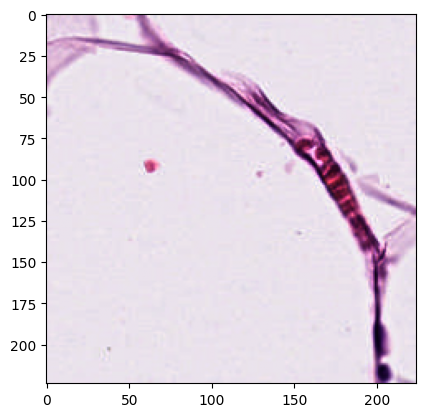

In [9]:
plt.imshow(all_images[0])

In [10]:
texts[0]

'An H&E image patch of adipose tissue.'

In [96]:
texts[1:10]

1    An H&E image patch of adipose tissue.
2    An H&E image patch of adipose tissue.
3    An H&E image patch of adipose tissue.
4    An H&E image patch of adipose tissue.
5    An H&E image patch of adipose tissue.
6    An H&E image patch of adipose tissue.
7    An H&E image patch of adipose tissue.
8    An H&E image patch of adipose tissue.
9    An H&E image patch of adipose tissue.
Name: caption, dtype: object

In [11]:
print(set(texts))

{'An H&E image patch of debris.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of normal colon mucosa.', 'An H&E image patch of lymphocytes.', 'An H&E image patch of cancer-associated stroma.', 'An H&E image patch of mucus.', 'An H&E image patch of adipose tissue.', 'An H&E image patch of background.', 'An H&E image patch of colorectal adenocarcinoma epithelium.'}


In [12]:
tif_files = []
for dirpath, _, filenames in os.walk("CRC-VAL-HE-7K"):
    for filename in [f for f in filenames if f.endswith('.tif')]:
        tif_files.append(os.path.join(dirpath, filename))

# Use Image.open() to load images and store them as PIL Images in a list
image_list = []
for tif_file in tif_files:
    with Image.open(tif_file).convert('RGB') as img:
        image_list.append(img.copy())

# Print the number of loaded images
print(f"Loaded {len(image_list)} images.")

Loaded 7180 images.


In [13]:
print(tif_files[1:10])

['CRC-VAL-HE-7K/ADI/ADI-TCGA-AAKTCYHC.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-AAWDNKDK.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-ACCKVFLM.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-ADCVKMNS.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-ADCWNRSF.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-ADEFMGRC.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-ADTVLITV.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-AECFTNDT.tif', 'CRC-VAL-HE-7K/ADI/ADI-TCGA-AEDALKHL.tif']


In [14]:
print(matched_df.iloc[1:10,0])

1    ADI-TCGA-AAKTCYHC.tif
2    ADI-TCGA-AAWDNKDK.tif
3    ADI-TCGA-ACCKVFLM.tif
4    ADI-TCGA-ADCVKMNS.tif
5    ADI-TCGA-ADCWNRSF.tif
6    ADI-TCGA-ADEFMGRC.tif
7    ADI-TCGA-ADTVLITV.tif
8    ADI-TCGA-AECFTNDT.tif
9    ADI-TCGA-AEDALKHL.tif
Name: filename, dtype: object


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [16]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Must set jit=False for training

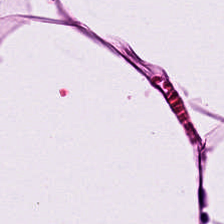

In [17]:
image_list[0]

In [18]:
print(np.shape(image_list[0]))

(224, 224, 3)


In [19]:
processed_images = []
for img in image_list:
    processed_img = preprocess(img)
    processed_images.append(processed_img)

In [20]:
len(processed_images)

7180

In [21]:
processed_images[100].shape

torch.Size([3, 224, 224])

In [22]:
dataloader_images = DataLoader(processed_images, batch_size=10, shuffle=False)

In [23]:
image_embeddings_initial = []
                      
total = len(processed_images) // 10
pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for images in dataloader_images:
        images = images.to(device)
        image_embeddings_initial.extend(model.encode_image(images).detach().cpu().numpy())
        pbar.update(1)
    pbar.close()
image_embeddings_initial = np.array(image_embeddings_initial)
print(image_embeddings_initial.shape)

100%|██████████| 718/718 [00:09<00:00, 74.93it/s]

(7180, 512)


In [24]:
dataloader_texts = DataLoader(texts, batch_size = 10, shuffle=False)

In [25]:
text_embeddings_initial = []
total = len(texts) // 10

pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for captions in dataloader_texts:
        idx = clip.tokenize(captions, truncate=True).to(device)
        text_embeddings_initial.extend(model.encode_text(idx).detach().cpu().numpy())

        pbar.update(1)

    pbar.close()

text_embeddings_initial = np.array(text_embeddings_initial)
print(text_embeddings_initial.shape)

100%|██████████| 718/718 [00:08<00:00, 83.75it/s]


(7180, 512)


In [26]:
image_embeddings_initial_norm = image_embeddings_initial / np.linalg.norm(image_embeddings_initial, axis=1, keepdims=True)
text_embeddings_initial_norm = text_embeddings_initial / np.linalg.norm(text_embeddings_initial, axis=1, keepdims=True)
print(image_embeddings_initial_norm.shape)
print(text_embeddings_initial_norm.shape)

(7180, 512)
(7180, 512)


In [27]:
# tsne = TSNE(n_components=3, random_state=0)
# embeddings_texts = tsne.fit_transform(text_embeddings_norm[:7000])
# embeddings_images = tsne.fit_transform(image_embeddings_norm[:7000]) 
# print(embeddings_texts.shape)
# print(embeddings_images.shape)

In [28]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(embeddings_images[:, 0], embeddings_images[:, 1], embeddings_images[:, 2], color='b', label='Image Embeddings')
# ax.scatter(embeddings_texts[:, 0], embeddings_texts[:, 1], embeddings_texts[:, 2], color='r', label='Text Embeddings')
# ax.legend()
# plt.show()

In [92]:
reducer = umap.UMAP(n_components=3, random_state=0)
embeddings_texts = reducer.fit_transform(text_embeddings_initial)
embeddings_images = reducer.fit_transform(image_embeddings_initial)
print(embeddings_texts.shape)
print(embeddings_images.shape)

(7180, 3)
(7180, 3)


In [31]:
class ContrastiveDataset(Dataset):
    def __init__(self, image_embeddings, text_embeddings):
        self.image_embeddings = image_embeddings
        self.text_embeddings = text_embeddings
        assert len(self.image_embeddings) == len(self.text_embeddings), "Mismatched embeddings lengths!"

    def __len__(self):
        return len(self.image_embeddings)

    def __getitem__(self, idx):
        return self.image_embeddings[idx], self.text_embeddings[idx]

In [32]:
epochs = 30
batch_size = 20
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Must set jit=False for training
# train_dataset = ContrastiveDataset(processed_images[:7000], text_embeddings_norm[:7000])
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
# num_batches_per_epoch = len(train_dataloader)
# print(num_batches_per_epoch)
# total_steps = len(train_dataloader) * epochs
# print(total_steps)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [33]:
# fixing the problem! 
train_dataset = ContrastiveDataset(processed_images, texts)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
num_batches_per_epoch = len(train_dataloader)
print(num_batches_per_epoch)
total_steps = len(train_dataloader) * epochs
print(total_steps)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

359
10770


In [34]:
test = next(iter(train_dataloader))
images1, texts1 = test
print(np.shape(images1))
print(np.shape(texts1))

torch.Size([20, 3, 224, 224])
(20,)


In [35]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [36]:
unique_texts = set(texts)
print(unique_texts)
print(len(unique_texts))

{'An H&E image patch of debris.', 'An H&E image patch of smooth muscle.', 'An H&E image patch of normal colon mucosa.', 'An H&E image patch of lymphocytes.', 'An H&E image patch of cancer-associated stroma.', 'An H&E image patch of mucus.', 'An H&E image patch of adipose tissue.', 'An H&E image patch of background.', 'An H&E image patch of colorectal adenocarcinoma epithelium.'}
9


In [37]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [38]:
# logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07)).exp() 
# nn.Parameter() is wrapping around a scalar value

# the ground truth is created based on the assumption that the dataset is aligned such that 
# each image at index i has its corresponding text also at index i

training_losses = []

for epoch in range(epochs):
    train_loss_this_epoch = 0
    
    for i, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"{epoch}/{epochs}", position=0)):
        optimizer.zero_grad()
        
        images_batch, texts_batch = batch
        images_batch = images_batch.to(device)
        texts_new = clip.tokenize(texts_batch, truncate=True).to(device)
        
        images_embeddings = model.encode_image(images_batch)
        texts_embeddings = model.encode_text(texts_new)
        
        images_embeddings_norm = images_embeddings / images_embeddings.norm(dim=1, keepdim=True)
        texts_embeddings_norm = texts_embeddings / texts_embeddings.norm(dim=1, keepdim=True)
        
        
        logit_scale = model.logit_scale.exp()
        # print(logit_scale) # tensor(100., device='cuda:0', grad_fn=<ExpBackward>)
        
        logits_per_image = logit_scale * images_embeddings_norm @ texts_embeddings_norm.t() # cosine similarity
        # (batch_size, embedding_dim) @ (embedding_dim, batch_size) = (batch_size, batch_size)
        # each row corresponds to an image
        logits_per_text = logits_per_image.t()
        # each row corresponds to a text
        
        # logits_per_image, logits_per_text = model(images_batch, texts_new)

        ground_truth = torch.arange(len(images_batch), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        
        total_loss.backward()
        train_loss_this_epoch += total_loss.detach().cpu().numpy() 
        # using .item() is more memory efficient for scalars comparing to .numpy()
        
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)
        
    print(f"train_loss_this_epoch is: {train_loss_this_epoch}")
    training_losses.append(train_loss_this_epoch)

0/30: 100%|██████████| 359/359 [00:42<00:00,  8.40it/s]


train_loss_this_epoch is: 1076.103515625


1/30: 100%|██████████| 359/359 [00:42<00:00,  8.42it/s]


train_loss_this_epoch is: 1075.60546875


2/30: 100%|██████████| 359/359 [00:42<00:00,  8.41it/s]


train_loss_this_epoch is: 1075.5859375


3/30: 100%|██████████| 359/359 [00:42<00:00,  8.47it/s]


train_loss_this_epoch is: 1075.59765625


4/30: 100%|██████████| 359/359 [00:42<00:00,  8.42it/s]


train_loss_this_epoch is: 1075.595703125


5/30: 100%|██████████| 359/359 [00:42<00:00,  8.40it/s]


train_loss_this_epoch is: 1075.60546875


6/30: 100%|██████████| 359/359 [00:42<00:00,  8.48it/s]


train_loss_this_epoch is: 1075.59375


7/30: 100%|██████████| 359/359 [00:42<00:00,  8.40it/s]


train_loss_this_epoch is: 1075.603515625


8/30: 100%|██████████| 359/359 [00:42<00:00,  8.40it/s]


train_loss_this_epoch is: 1075.58984375


9/30: 100%|██████████| 359/359 [00:42<00:00,  8.48it/s]


train_loss_this_epoch is: 1075.59375


10/30: 100%|██████████| 359/359 [00:42<00:00,  8.42it/s]


train_loss_this_epoch is: 1075.595703125


11/30: 100%|██████████| 359/359 [00:42<00:00,  8.50it/s]


train_loss_this_epoch is: 1075.59375


12/30: 100%|██████████| 359/359 [00:42<00:00,  8.47it/s]


train_loss_this_epoch is: 1075.607421875


13/30: 100%|██████████| 359/359 [00:42<00:00,  8.45it/s]


train_loss_this_epoch is: 1075.603515625


14/30: 100%|██████████| 359/359 [00:42<00:00,  8.53it/s]


train_loss_this_epoch is: 1075.599609375


15/30: 100%|██████████| 359/359 [00:42<00:00,  8.44it/s]


train_loss_this_epoch is: 1075.59765625


16/30: 100%|██████████| 359/359 [00:42<00:00,  8.48it/s]


train_loss_this_epoch is: 1075.59765625


17/30: 100%|██████████| 359/359 [00:42<00:00,  8.51it/s]


train_loss_this_epoch is: 1075.60546875


18/30: 100%|██████████| 359/359 [00:42<00:00,  8.46it/s]


train_loss_this_epoch is: 1075.58984375


19/30: 100%|██████████| 359/359 [00:42<00:00,  8.52it/s]


train_loss_this_epoch is: 1075.6015625


20/30: 100%|██████████| 359/359 [00:42<00:00,  8.46it/s]


train_loss_this_epoch is: 1075.595703125


21/30: 100%|██████████| 359/359 [00:42<00:00,  8.46it/s]


train_loss_this_epoch is: 1075.603515625


22/30: 100%|██████████| 359/359 [00:42<00:00,  8.51it/s]


train_loss_this_epoch is: 1075.6015625


23/30: 100%|██████████| 359/359 [00:42<00:00,  8.46it/s]


train_loss_this_epoch is: 1075.595703125


24/30: 100%|██████████| 359/359 [00:42<00:00,  8.46it/s]


train_loss_this_epoch is: 1075.607421875


25/30: 100%|██████████| 359/359 [00:42<00:00,  8.52it/s]


train_loss_this_epoch is: 1075.59375


26/30: 100%|██████████| 359/359 [00:42<00:00,  8.44it/s]


train_loss_this_epoch is: 1075.599609375


27/30: 100%|██████████| 359/359 [00:42<00:00,  8.52it/s]


train_loss_this_epoch is: 1075.599609375


28/30: 100%|██████████| 359/359 [00:42<00:00,  8.46it/s]


train_loss_this_epoch is: 1075.58984375


29/30: 100%|██████████| 359/359 [00:42<00:00,  8.45it/s]

train_loss_this_epoch is: 1075.59765625


In [39]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        
# The logit scale is just one part of the process, and it's essentially adjusting the magnitude of the logits.
# logit_scale torch.Size([])

positional_embedding torch.Size([77, 512])
text_projection torch.Size([512, 512])
logit_scale torch.Size([])
visual.class_embedding torch.Size([768])
visual.positional_embedding torch.Size([50, 768])
visual.proj torch.Size([768, 512])
visual.conv1.weight torch.Size([768, 3, 32, 32])
visual.ln_pre.weight torch.Size([768])
visual.ln_pre.bias torch.Size([768])
visual.transformer.resblocks.0.attn.in_proj_weight torch.Size([2304, 768])
visual.transformer.resblocks.0.attn.in_proj_bias torch.Size([2304])
visual.transformer.resblocks.0.attn.out_proj.weight torch.Size([768, 768])
visual.transformer.resblocks.0.attn.out_proj.bias torch.Size([768])
visual.transformer.resblocks.0.ln_1.weight torch.Size([768])
visual.transformer.resblocks.0.ln_1.bias torch.Size([768])
visual.transformer.resblocks.0.mlp.c_fc.weight torch.Size([3072, 768])
visual.transformer.resblocks.0.mlp.c_fc.bias torch.Size([3072])
visual.transformer.resblocks.0.mlp.c_proj.weight torch.Size([768, 3072])
visual.transformer.resbloc

In [40]:
image_embeddings_trained = []
                      
total = len(processed_images) // 10
pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for images in dataloader_images:
        images = images.to(device)
        image_embeddings_trained.extend(model.encode_image(images).detach().cpu().numpy())
        pbar.update(1)
    pbar.close()
image_embeddings_trained = np.array(image_embeddings_trained)
print(image_embeddings_trained.shape)

100%|██████████| 718/718 [00:09<00:00, 76.09it/s]

(7180, 512)


In [41]:
text_embeddings_trained = []

total = len(texts) // 10
pbar = tqdm.tqdm(total=total, position=0)
with torch.no_grad():
    for captions in dataloader_texts:
        idx = clip.tokenize(captions, truncate=True).to(device)
        text_embeddings_trained.extend(model.encode_text(idx).detach().cpu().numpy())

        pbar.update(1)

    pbar.close()

text_embeddings_trained = np.array(text_embeddings_trained)
print(text_embeddings_trained.shape)

100%|██████████| 718/718 [00:08<00:00, 84.75it/s]

(7180, 512)


In [93]:
reducer = umap.UMAP(n_components=3, random_state=0)
embeddings_texts_trained = reducer.fit_transform(text_embeddings_trained)
embeddings_images_trained = reducer.fit_transform(image_embeddings_trained)

In [84]:
image_embeddings_trained_norm = image_embeddings_trained / np.linalg.norm(image_embeddings_trained, axis=1, keepdims=True)
text_embeddings_trained_norm = text_embeddings_trained / np.linalg.norm(text_embeddings_trained, axis=1, keepdims=True)
print(image_embeddings_trained_norm.shape)
print(text_embeddings_trained_norm.shape)

(7180, 512)
(7180, 512)


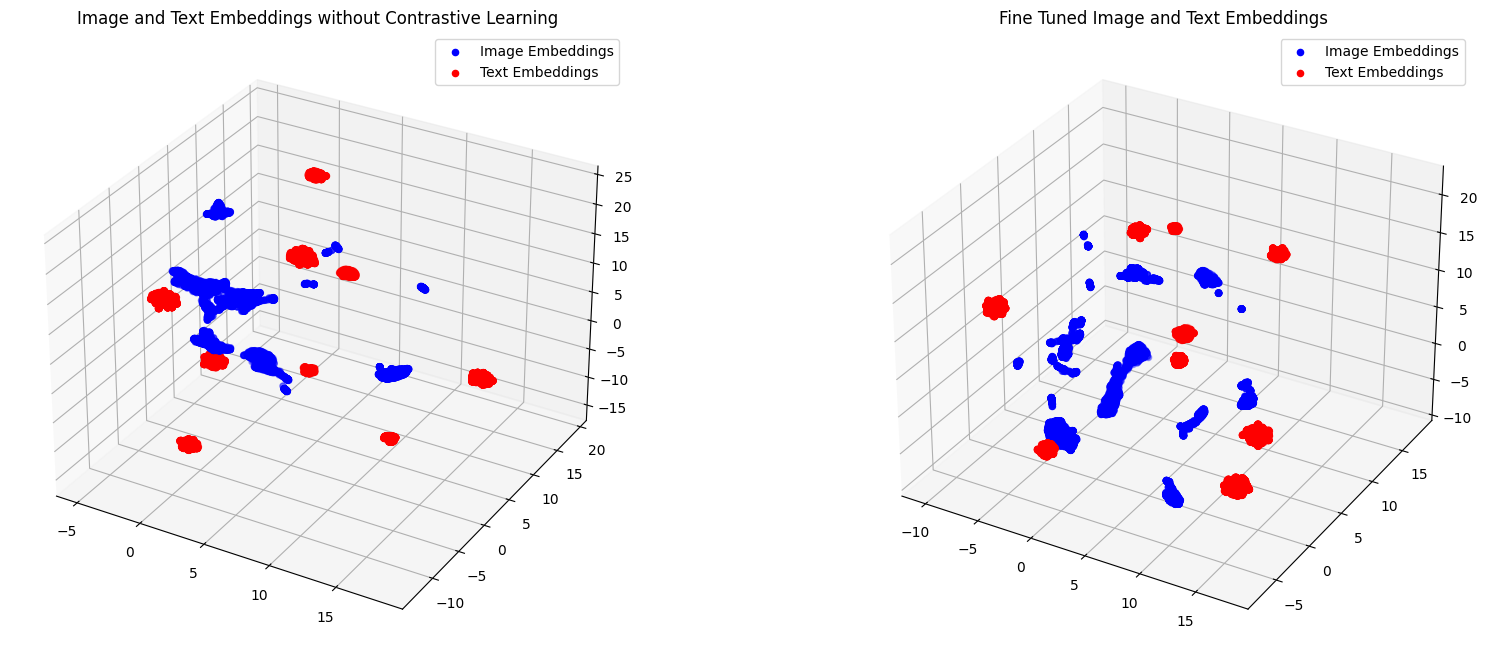

In [94]:
fig = plt.figure(figsize=(20, 8))  

# First plot
ax1 = fig.add_subplot(121, projection='3d')  
ax1.scatter(embeddings_images[:, 0], embeddings_images[:, 1], embeddings_images[:, 2], color='b', label='Image Embeddings')
ax1.scatter(embeddings_texts[:, 0], embeddings_texts[:, 1], embeddings_texts[:, 2], color='r', label='Text Embeddings')
ax1.legend()
ax1.set_title('Image and Text Embeddings without Contrastive Learning')

# Second plot
ax2 = fig.add_subplot(122, projection='3d') 
ax2.scatter(embeddings_images_trained[:, 0], embeddings_images_trained[:, 1], embeddings_images_trained[:, 2], color='b', label='Image Embeddings')
ax2.scatter(embeddings_texts_trained[:, 0], embeddings_texts_trained[:, 1], embeddings_texts_trained[:, 2], color='r', label='Text Embeddings')
ax2.legend()
ax2.set_title('Fine Tuned Image and Text Embeddings')

plt.show()

In [86]:
reducer = umap.UMAP(n_components=3, random_state=0)
embeddings_texts_norm = reducer.fit_transform(text_embeddings_initial_norm)
embeddings_images_norm = reducer.fit_transform(image_embeddings_initial_norm)
embeddings_texts_trained_norm = reducer.fit_transform(text_embeddings_trained_norm)
embeddings_images_trained_norm = reducer.fit_transform(image_embeddings_trained_norm)

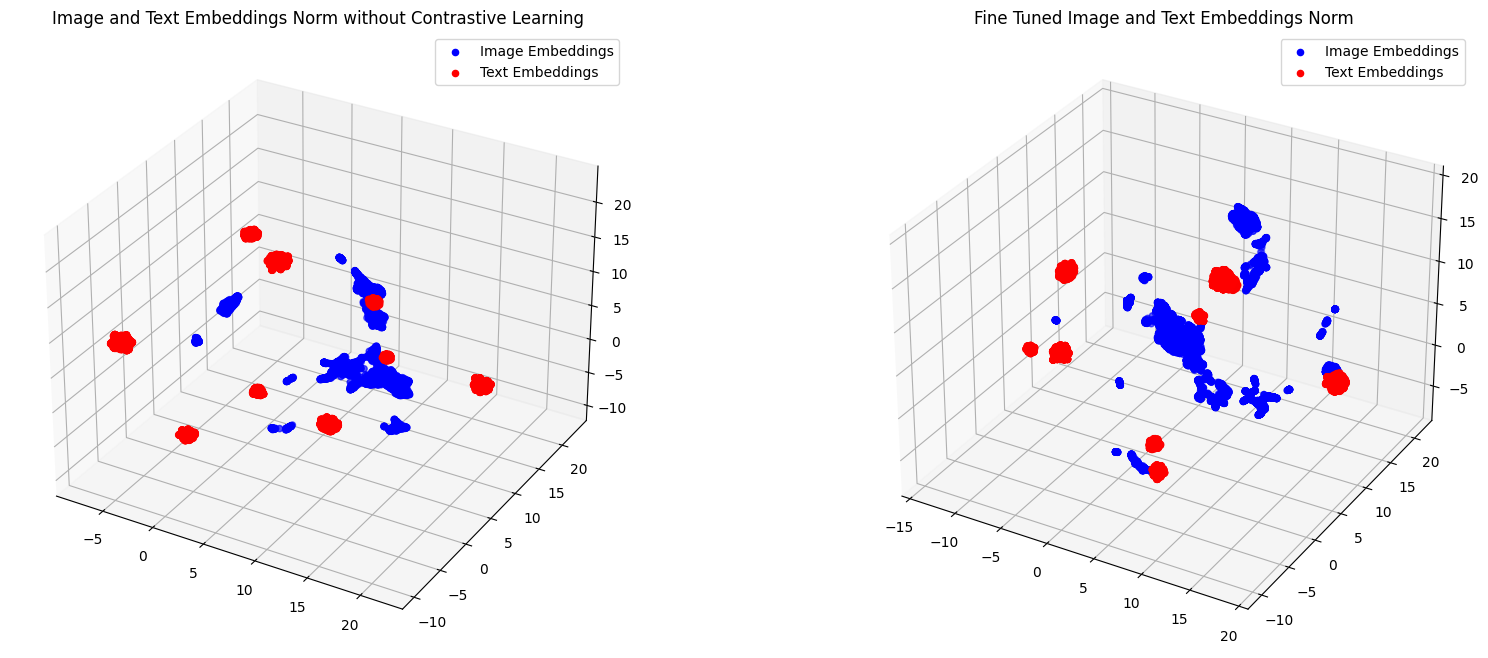

In [91]:
fig = plt.figure(figsize=(20, 8))  

# First plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(embeddings_images_norm[:, 0], embeddings_images_norm[:, 1], embeddings_images_norm[:, 2], color='b', label='Image Embeddings')
ax1.scatter(embeddings_texts_norm[:, 0], embeddings_texts_norm[:, 1], embeddings_texts_norm[:, 2], color='r', label='Text Embeddings')
ax1.legend()
ax1.set_title('Image and Text Embeddings Norm without Contrastive Learning')

# Second plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embeddings_images_trained_norm[:, 0], embeddings_images_trained_norm[:, 1], embeddings_images_trained_norm[:, 2], color='b', label='Image Embeddings')
ax2.scatter(embeddings_texts_trained_norm[:, 0], embeddings_texts_trained_norm[:, 1], embeddings_texts_trained_norm[:, 2], color='r', label='Text Embeddings')
ax2.legend()
ax2.set_title('Fine Tuned Image and Text Embeddings Norm')

plt.show()

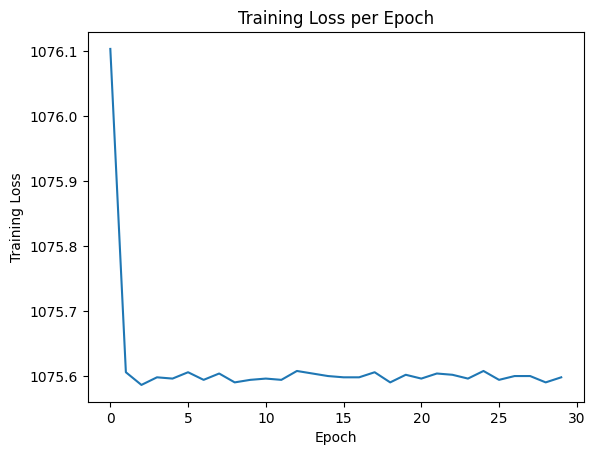

In [46]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')
plt.show()

In [47]:
def calculate_f1_score(self, outputs, labels, average='weighted'):
    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted_labels = np.argmax(outputs, axis=1)
    # axis = 1 returns the index of the maximum value along each row
    f1 = f1_score(labels, predicted_labels, average=average)
    return f1

In [48]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
        # input: (batch_size, input_size)
        # output: (batch_Size, num_classes)
        
    def forward(self, x):
        x = x.to(self.fc.weight.dtype)
        # ensuring that the input x has the same data type
        out = self.fc(x)
        return out

In [49]:
input_size = 512
num_classes = len(unique_texts)
linear_classifier = LinearClassifier(input_size, num_classes)
linear_classifier = linear_classifier.to(device)

In [50]:
descriptions = {
    'An H&E image patch of cancer-associated stroma.', 
    'An H&E image patch of lymphocytes.', 
    'An H&E image patch of mucus.', 
    'An H&E image patch of smooth muscle.', 
    'An H&E image patch of background.', 
    'An H&E image patch of normal colon mucosa.', 
    'An H&E image patch of debris.', 
    'An H&E image patch of colorectal adenocarcinoma epithelium.', 
    'An H&E image patch of adipose tissue.'
}

labels = [' '.join(desc.split()[5:]).rstrip('.') for desc in descriptions]

print(labels)
print(labels[3])

['debris', 'smooth muscle', 'normal colon mucosa', 'lymphocytes', 'cancer-associated stroma', 'mucus', 'adipose tissue', 'background', 'colorectal adenocarcinoma epithelium']
lymphocytes


In [51]:
label_to_int = {label: idx for idx, label in enumerate(labels)}
int_labels = [label_to_int[label] for label in labels]
print(int_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [52]:
texts_labels = [' '.join(desc.split()[5:]).rstrip('.') for desc in texts]
print(texts_labels[0:10])

['adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue', 'adipose tissue']


In [53]:
texts_labels_int = [label_to_int[label] for label in texts_labels]
texts_labels_int = np.array(texts_labels_int)
print(texts_labels_int[0:10])

[6 6 6 6 6 6 6 6 6 6]


In [54]:
class LinearClassifierDataset(Dataset):
    def __init__(self, image_embeddings, labels):
        self.image_embeddings = image_embeddings
        self.labels = labels
        assert len(self.image_embeddings) == len(self.labels), "Mismatched Lengths!"

    def __len__(self):
        return len(self.image_embeddings)

    def __getitem__(self, idx):
        return self.image_embeddings[idx], self.labels[idx]

In [55]:
print(texts_labels_int.shape)

(7180,)


In [56]:
epochs = 100
batch_size = 20
train_dataset_linear_classifier = LinearClassifierDataset(image_embeddings_initial[:7000], texts_labels_int[:7000])
train_dataloader_linear_classifier = DataLoader(train_dataset_linear_classifier, batch_size=batch_size)
num_batches_per_epoch = len(train_dataloader_linear_classifier)
print(num_batches_per_epoch)
total_steps = len(train_dataloader_linear_classifier) * epochs
print(total_steps)
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.0001)

350
35000


In [57]:
for name, param in linear_classifier.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

fc.weight torch.Size([9, 512])
fc.bias torch.Size([9])


In [58]:
training_losses_linear_classifier = []
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    train_loss_this_epoch = 0
    for i, batch in enumerate(tqdm.tqdm(train_dataloader_linear_classifier, desc=f"{epoch}/{epochs}", position=0)):
        optimizer.zero_grad()

        images_embeddings, labels = batch
        images_embeddings = images_embeddings.to(device)
        labels = labels.to(device)
        
        outputs = linear_classifier(images_embeddings)
        total_loss = criterion(outputs, labels)  
        
        total_loss.backward()
        train_loss_this_epoch += total_loss.detach().cpu().item()  
        
        optimizer.step()
        
    print(f"train_loss_this_epoch is: {train_loss_this_epoch}")
    training_losses_linear_classifier.append(train_loss_this_epoch)

0/100: 100%|██████████| 350/350 [00:00<00:00, 1045.74it/s]


train_loss_this_epoch is: 811.2545610666275


1/100: 100%|██████████| 350/350 [00:00<00:00, 1047.40it/s]


train_loss_this_epoch is: 613.4297203421593


2/100: 100%|██████████| 350/350 [00:00<00:00, 1058.75it/s]


train_loss_this_epoch is: 537.5951923131943


3/100: 100%|██████████| 350/350 [00:00<00:00, 1045.67it/s]


train_loss_this_epoch is: 476.97252121567726


4/100: 100%|██████████| 350/350 [00:00<00:00, 1061.75it/s]


train_loss_this_epoch is: 429.31860350072384


5/100: 100%|██████████| 350/350 [00:00<00:00, 1051.75it/s]


train_loss_this_epoch is: 391.3508909717202


6/100: 100%|██████████| 350/350 [00:00<00:00, 1046.23it/s]


train_loss_this_epoch is: 360.1772750765085


7/100: 100%|██████████| 350/350 [00:00<00:00, 1061.42it/s]


train_loss_this_epoch is: 333.9337579533458


8/100: 100%|██████████| 350/350 [00:00<00:00, 1046.87it/s]


train_loss_this_epoch is: 311.42255203425884


9/100: 100%|██████████| 350/350 [00:00<00:00, 1056.13it/s]


train_loss_this_epoch is: 291.8377718105912


10/100: 100%|██████████| 350/350 [00:00<00:00, 1047.52it/s]


train_loss_this_epoch is: 274.6104381084442


11/100: 100%|██████████| 350/350 [00:00<00:00, 1057.78it/s]


train_loss_this_epoch is: 259.32160817086697


12/100: 100%|██████████| 350/350 [00:00<00:00, 1046.93it/s]


train_loss_this_epoch is: 245.6523986812681


13/100: 100%|██████████| 350/350 [00:00<00:00, 1062.21it/s]


train_loss_this_epoch is: 233.3535463185981


14/100: 100%|██████████| 350/350 [00:00<00:00, 1042.13it/s]


train_loss_this_epoch is: 222.2264440143481


15/100: 100%|██████████| 350/350 [00:00<00:00, 1066.30it/s]


train_loss_this_epoch is: 212.110457633622


16/100: 100%|██████████| 350/350 [00:00<00:00, 1047.87it/s]


train_loss_this_epoch is: 202.8740225378424


17/100: 100%|██████████| 350/350 [00:00<00:00, 1053.13it/s]


train_loss_this_epoch is: 194.4082923317328


18/100: 100%|██████████| 350/350 [00:00<00:00, 1059.20it/s]


train_loss_this_epoch is: 186.6223670677282


19/100: 100%|██████████| 350/350 [00:00<00:00, 1056.94it/s]


train_loss_this_epoch is: 179.4396052286029


20/100: 100%|██████████| 350/350 [00:00<00:00, 1057.81it/s]


train_loss_this_epoch is: 172.79487301316112


21/100: 100%|██████████| 350/350 [00:00<00:00, 1042.64it/s]


train_loss_this_epoch is: 166.63231519097462


22/100: 100%|██████████| 350/350 [00:00<00:00, 1064.72it/s]


train_loss_this_epoch is: 160.9037094505038


23/100: 100%|██████████| 350/350 [00:00<00:00, 1041.31it/s]


train_loss_this_epoch is: 155.56708902283572


24/100: 100%|██████████| 350/350 [00:00<00:00, 1062.59it/s]


train_loss_this_epoch is: 150.5857147735078


25/100: 100%|██████████| 350/350 [00:00<00:00, 1045.97it/s]


train_loss_this_epoch is: 145.92724884022027


26/100: 100%|██████████| 350/350 [00:00<00:00, 1059.24it/s]


train_loss_this_epoch is: 141.56305087194778


27/100: 100%|██████████| 350/350 [00:00<00:00, 1046.21it/s]


train_loss_this_epoch is: 137.4677010937594


28/100: 100%|██████████| 350/350 [00:00<00:00, 1058.10it/s]


train_loss_this_epoch is: 133.6184800346382


29/100: 100%|██████████| 350/350 [00:00<00:00, 1051.94it/s]


train_loss_this_epoch is: 129.99508174788207


30/100: 100%|██████████| 350/350 [00:00<00:00, 1059.28it/s]


train_loss_this_epoch is: 126.57926478749141


31/100: 100%|██████████| 350/350 [00:00<00:00, 1051.18it/s]


train_loss_this_epoch is: 123.35459750832524


32/100: 100%|██████████| 350/350 [00:00<00:00, 1053.60it/s]


train_loss_this_epoch is: 120.3062690384686


33/100: 100%|██████████| 350/350 [00:00<00:00, 1061.88it/s]


train_loss_this_epoch is: 117.42086052591912


34/100: 100%|██████████| 350/350 [00:00<00:00, 1042.85it/s]


train_loss_this_epoch is: 114.68622674036305


35/100: 100%|██████████| 350/350 [00:00<00:00, 1063.19it/s]


train_loss_this_epoch is: 112.09133169951383


36/100: 100%|██████████| 350/350 [00:00<00:00, 1044.75it/s]


train_loss_this_epoch is: 109.62613968527876


37/100: 100%|██████████| 350/350 [00:00<00:00, 1058.31it/s]


train_loss_this_epoch is: 107.28149504656903


38/100: 100%|██████████| 350/350 [00:00<00:00, 1046.30it/s]


train_loss_this_epoch is: 105.04904972435907


39/100: 100%|██████████| 350/350 [00:00<00:00, 1062.29it/s]


train_loss_this_epoch is: 102.92116039257962


40/100: 100%|██████████| 350/350 [00:00<00:00, 1041.66it/s]


train_loss_this_epoch is: 100.89082958665676


41/100: 100%|██████████| 350/350 [00:00<00:00, 1062.70it/s]


train_loss_this_epoch is: 98.95164239266887


42/100: 100%|██████████| 350/350 [00:00<00:00, 1051.09it/s]


train_loss_this_epoch is: 97.09770055493573


43/100: 100%|██████████| 350/350 [00:00<00:00, 1016.13it/s]


train_loss_this_epoch is: 95.3235909792129


44/100: 100%|██████████| 350/350 [00:00<00:00, 1056.57it/s]


train_loss_this_epoch is: 93.62430334941018


45/100: 100%|██████████| 350/350 [00:00<00:00, 1047.38it/s]


train_loss_this_epoch is: 91.9952417712193


46/100: 100%|██████████| 350/350 [00:00<00:00, 1067.61it/s]


train_loss_this_epoch is: 90.43216101650614


47/100: 100%|██████████| 350/350 [00:00<00:00, 1046.08it/s]


train_loss_this_epoch is: 88.9311373300734


48/100: 100%|██████████| 350/350 [00:00<00:00, 1064.18it/s]


train_loss_this_epoch is: 87.48851519398158


49/100: 100%|██████████| 350/350 [00:00<00:00, 1043.27it/s]


train_loss_this_epoch is: 86.100939873897


50/100: 100%|██████████| 350/350 [00:00<00:00, 1069.53it/s]


train_loss_this_epoch is: 84.76529476721771


51/100: 100%|██████████| 350/350 [00:00<00:00, 1046.74it/s]


train_loss_this_epoch is: 83.47867300687358


52/100: 100%|██████████| 350/350 [00:00<00:00, 1056.76it/s]


train_loss_this_epoch is: 82.23837991076289


53/100: 100%|██████████| 350/350 [00:00<00:00, 1042.85it/s]


train_loss_this_epoch is: 81.04191361484118


54/100: 100%|██████████| 350/350 [00:00<00:00, 1065.37it/s]


train_loss_this_epoch is: 79.88694672146812


55/100: 100%|██████████| 350/350 [00:00<00:00, 1047.76it/s]


train_loss_this_epoch is: 78.77130294061499


56/100: 100%|██████████| 350/350 [00:00<00:00, 1056.54it/s]


train_loss_this_epoch is: 77.69294769465341


57/100: 100%|██████████| 350/350 [00:00<00:00, 1062.59it/s]


train_loss_this_epoch is: 76.65000590286218


58/100: 100%|██████████| 350/350 [00:00<00:00, 1044.03it/s]


train_loss_this_epoch is: 75.64069736239617


59/100: 100%|██████████| 350/350 [00:00<00:00, 1059.43it/s]


train_loss_this_epoch is: 74.66336331341881


60/100: 100%|██████████| 350/350 [00:00<00:00, 1043.70it/s]


train_loss_this_epoch is: 73.71646453122958


61/100: 100%|██████████| 350/350 [00:00<00:00, 1056.72it/s]


train_loss_this_epoch is: 72.79854713703389


62/100: 100%|██████████| 350/350 [00:00<00:00, 1045.90it/s]


train_loss_this_epoch is: 71.90824373721262


63/100: 100%|██████████| 350/350 [00:00<00:00, 1030.74it/s]


train_loss_this_epoch is: 71.04428611029289


64/100: 100%|██████████| 350/350 [00:00<00:00, 1046.62it/s]


train_loss_this_epoch is: 70.2054658185807


65/100: 100%|██████████| 350/350 [00:00<00:00, 1057.44it/s]


train_loss_this_epoch is: 69.39065998399747


66/100: 100%|██████████| 350/350 [00:00<00:00, 1049.98it/s]


train_loss_this_epoch is: 68.59880401197006


67/100: 100%|██████████| 350/350 [00:00<00:00, 1040.28it/s]


train_loss_this_epoch is: 67.82890121190576


68/100: 100%|██████████| 350/350 [00:00<00:00, 1054.61it/s]


train_loss_this_epoch is: 67.0799997310387


69/100: 100%|██████████| 350/350 [00:00<00:00, 1051.52it/s]


train_loss_this_epoch is: 66.35122088735807


70/100: 100%|██████████| 350/350 [00:00<00:00, 1052.33it/s]


train_loss_this_epoch is: 65.64171780616743


71/100: 100%|██████████| 350/350 [00:00<00:00, 1048.05it/s]


train_loss_this_epoch is: 64.95069828348642


72/100: 100%|██████████| 350/350 [00:00<00:00, 1059.50it/s]


train_loss_this_epoch is: 64.2774148202443


73/100: 100%|██████████| 350/350 [00:00<00:00, 998.32it/s] 


train_loss_this_epoch is: 63.62115766192437


74/100: 100%|██████████| 350/350 [00:00<00:00, 1058.29it/s]


train_loss_this_epoch is: 62.98125198727939


75/100: 100%|██████████| 350/350 [00:00<00:00, 1046.34it/s]


train_loss_this_epoch is: 62.35706605852465


76/100: 100%|██████████| 350/350 [00:00<00:00, 1058.53it/s]


train_loss_this_epoch is: 61.74799443266238


77/100: 100%|██████████| 350/350 [00:00<00:00, 1048.15it/s]


train_loss_this_epoch is: 61.153462516507716


78/100: 100%|██████████| 350/350 [00:00<00:00, 1012.05it/s]


train_loss_this_epoch is: 60.57292918002349


79/100: 100%|██████████| 350/350 [00:00<00:00, 1054.37it/s]


train_loss_this_epoch is: 60.00587419423391


80/100: 100%|██████████| 350/350 [00:00<00:00, 1051.22it/s]


train_loss_this_epoch is: 59.45181313813373


81/100: 100%|██████████| 350/350 [00:00<00:00, 1054.15it/s]


train_loss_this_epoch is: 58.91028403049859


82/100: 100%|██████████| 350/350 [00:00<00:00, 999.85it/s] 


train_loss_this_epoch is: 58.38082758928067


83/100: 100%|██████████| 350/350 [00:00<00:00, 1058.90it/s]


train_loss_this_epoch is: 57.86302989833348


84/100: 100%|██████████| 350/350 [00:00<00:00, 1000.64it/s]


train_loss_this_epoch is: 57.35647910642729


85/100: 100%|██████████| 350/350 [00:00<00:00, 1061.66it/s]


train_loss_this_epoch is: 56.86080210268847


86/100: 100%|██████████| 350/350 [00:00<00:00, 1049.12it/s]


train_loss_this_epoch is: 56.37562696598616


87/100: 100%|██████████| 350/350 [00:00<00:00, 1057.40it/s]


train_loss_this_epoch is: 55.90060327027459


88/100: 100%|██████████| 350/350 [00:00<00:00, 1050.40it/s]


train_loss_this_epoch is: 55.43539726112067


89/100: 100%|██████████| 350/350 [00:00<00:00, 1049.27it/s]


train_loss_this_epoch is: 54.979690182321065


90/100: 100%|██████████| 350/350 [00:00<00:00, 1051.52it/s]


train_loss_this_epoch is: 54.53317496975069


91/100: 100%|██████████| 350/350 [00:00<00:00, 1048.62it/s]


train_loss_this_epoch is: 54.09556025979691


92/100: 100%|██████████| 350/350 [00:00<00:00, 1049.39it/s]


train_loss_this_epoch is: 53.666563798775314


93/100: 100%|██████████| 350/350 [00:00<00:00, 1050.37it/s]


train_loss_this_epoch is: 53.245922048830835


94/100: 100%|██████████| 350/350 [00:00<00:00, 1047.70it/s]


train_loss_this_epoch is: 52.83337588600989


95/100: 100%|██████████| 350/350 [00:00<00:00, 1038.18it/s]


train_loss_this_epoch is: 52.42868244455167


96/100: 100%|██████████| 350/350 [00:00<00:00, 1058.30it/s]


train_loss_this_epoch is: 52.03159604351822


97/100: 100%|██████████| 350/350 [00:00<00:00, 1044.97it/s]


train_loss_this_epoch is: 51.64190644076734


98/100: 100%|██████████| 350/350 [00:00<00:00, 1060.62it/s]


train_loss_this_epoch is: 51.25937993048865


99/100: 100%|██████████| 350/350 [00:00<00:00, 1047.03it/s]

train_loss_this_epoch is: 50.883815739849524


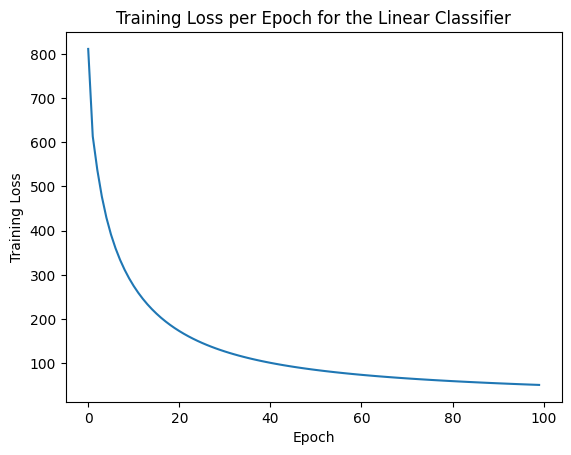

In [59]:
plt.plot(training_losses_linear_classifier)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for the Linear Classifier')
plt.show()

In [60]:
test_dataset_linear_classifier = LinearClassifierDataset(image_embeddings_initial[7000:], texts_labels_int[7000:])
test_dataloader_linear_classifier = DataLoader(test_dataset_linear_classifier, batch_size=batch_size)

In [61]:
linear_classifier.eval()

outputs_list = []
labels_list = []
total_loss = 0

with torch.no_grad():
    for batch in test_dataloader_linear_classifier:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
    
        outputs = linear_classifier(images)
        outputs_list.append(outputs)
        labels_list.append(labels)
    
        batch_loss = criterion(outputs, labels)
        total_loss += batch_loss.detach().cpu().item()

print(total_loss)
print(len(outputs_list))

1.1676132939755917
9


In [62]:
outputs_all = torch.cat(outputs_list, dim=0)
labels_all = torch.cat(labels_list, dim=0)
outputs_all = outputs_all.detach().cpu().numpy()
labels_all = labels_all.detach().cpu().numpy()
print(outputs_all.shape)
print(labels_all.shape)

(180, 9)
(180,)


In [63]:
predicted_labels = np.argmax(outputs_all, axis=1) # row-wise argmax 
print(predicted_labels.shape)
f1 = f1_score(labels_all, predicted_labels, average="weighted")
print(f1)

(180,)
0.9915966386554621


In [64]:
input_size = 512
num_classes = len(unique_texts)
linear_classifier_two = LinearClassifier(input_size, num_classes)
linear_classifier_two = linear_classifier_two.to(device)
optimizer_two = optim.Adam(linear_classifier_two.parameters(), lr=0.0001)

In [65]:
train_dataset_linear_classifier_new = LinearClassifierDataset(image_embeddings_trained[:7000], texts_labels_int[:7000])
train_dataloader_linear_classifier_new = DataLoader(train_dataset_linear_classifier_new, batch_size=batch_size)

In [66]:
training_losses_linear_classifier_new = []

for epoch in range(epochs):
    train_loss_this_epoch = 0
    for i, batch in enumerate(tqdm.tqdm(train_dataloader_linear_classifier_new, desc=f"{epoch}/{epochs}", position=0)):
        optimizer_two.zero_grad()

        images_embeddings, labels = batch
        images_embeddings = images_embeddings.to(device)
        labels = labels.to(device)
        
        outputs = linear_classifier_two(images_embeddings)
        total_loss = criterion(outputs, labels)  
        
        total_loss.backward()
        train_loss_this_epoch += total_loss.detach().cpu().item()  
        
        optimizer_two.step()
        
    print(f"train_loss_this_epoch is: {train_loss_this_epoch}")
    training_losses_linear_classifier_new.append(train_loss_this_epoch)

0/100: 100%|██████████| 350/350 [00:00<00:00, 1046.87it/s]


train_loss_this_epoch is: 1317.1444950192335


1/100: 100%|██████████| 350/350 [00:00<00:00, 1061.29it/s]


train_loss_this_epoch is: 1373.3616747055148


2/100: 100%|██████████| 350/350 [00:00<00:00, 1057.71it/s]


train_loss_this_epoch is: 1299.5864879818891


3/100: 100%|██████████| 350/350 [00:00<00:00, 1057.26it/s]


train_loss_this_epoch is: 1295.2184838455469


4/100: 100%|██████████| 350/350 [00:00<00:00, 1061.30it/s]


train_loss_this_epoch is: 1295.2136745734465


5/100: 100%|██████████| 350/350 [00:00<00:00, 1055.26it/s]


train_loss_this_epoch is: 1280.3482254849844


6/100: 100%|██████████| 350/350 [00:00<00:00, 1065.14it/s]


train_loss_this_epoch is: 1279.1336041939658


7/100: 100%|██████████| 350/350 [00:00<00:00, 1059.98it/s]


train_loss_this_epoch is: 1278.8689706784005


8/100: 100%|██████████| 350/350 [00:00<00:00, 1049.44it/s]


train_loss_this_epoch is: 1277.1743627955273


9/100: 100%|██████████| 350/350 [00:00<00:00, 1057.55it/s]


train_loss_this_epoch is: 1277.133647524011


10/100: 100%|██████████| 350/350 [00:00<00:00, 1059.60it/s]


train_loss_this_epoch is: 1276.7386528251131


11/100: 100%|██████████| 350/350 [00:00<00:00, 1062.26it/s]


train_loss_this_epoch is: 1276.6990321400622


12/100: 100%|██████████| 350/350 [00:00<00:00, 1058.14it/s]


train_loss_this_epoch is: 1276.790264468337


13/100: 100%|██████████| 350/350 [00:00<00:00, 1054.26it/s]


train_loss_this_epoch is: 1276.7864388922367


14/100: 100%|██████████| 350/350 [00:00<00:00, 1062.56it/s]


train_loss_this_epoch is: 1276.8184306207065


15/100: 100%|██████████| 350/350 [00:00<00:00, 1061.22it/s]


train_loss_this_epoch is: 1276.8521651010753


16/100: 100%|██████████| 350/350 [00:00<00:00, 1055.62it/s]


train_loss_this_epoch is: 1276.870822894801


17/100: 100%|██████████| 350/350 [00:00<00:00, 1059.27it/s]


train_loss_this_epoch is: 1276.8898539135378


18/100: 100%|██████████| 350/350 [00:00<00:00, 1056.88it/s]


train_loss_this_epoch is: 1276.9011641106752


19/100: 100%|██████████| 350/350 [00:00<00:00, 1055.04it/s]


train_loss_this_epoch is: 1276.910074503929


20/100: 100%|██████████| 350/350 [00:00<00:00, 1057.29it/s]


train_loss_this_epoch is: 1276.9170704121047


21/100: 100%|██████████| 350/350 [00:00<00:00, 1059.09it/s]


train_loss_this_epoch is: 1276.9218238100984


22/100: 100%|██████████| 350/350 [00:00<00:00, 1022.93it/s]


train_loss_this_epoch is: 1276.92659284784


23/100: 100%|██████████| 350/350 [00:00<00:00, 1062.38it/s]


train_loss_this_epoch is: 1276.9296153098946


24/100: 100%|██████████| 350/350 [00:00<00:00, 1058.78it/s]


train_loss_this_epoch is: 1276.9313663394626


25/100: 100%|██████████| 350/350 [00:00<00:00, 1060.73it/s]


train_loss_this_epoch is: 1276.9333371827631


26/100: 100%|██████████| 350/350 [00:00<00:00, 1050.60it/s]


train_loss_this_epoch is: 1276.9341008084746


27/100: 100%|██████████| 350/350 [00:00<00:00, 1059.51it/s]


train_loss_this_epoch is: 1276.9344603836737


28/100: 100%|██████████| 350/350 [00:00<00:00, 1048.78it/s]


train_loss_this_epoch is: 1276.9346850610393


29/100: 100%|██████████| 350/350 [00:00<00:00, 1059.68it/s]


train_loss_this_epoch is: 1276.934807319766


30/100: 100%|██████████| 350/350 [00:00<00:00, 1057.63it/s]


train_loss_this_epoch is: 1276.9346354063498


31/100: 100%|██████████| 350/350 [00:00<00:00, 1052.38it/s]


train_loss_this_epoch is: 1276.9341019221508


32/100: 100%|██████████| 350/350 [00:00<00:00, 1059.06it/s]


train_loss_this_epoch is: 1276.9333826303089


33/100: 100%|██████████| 350/350 [00:00<00:00, 1059.64it/s]


train_loss_this_epoch is: 1276.9329920554367


34/100: 100%|██████████| 350/350 [00:00<00:00, 1055.80it/s]


train_loss_this_epoch is: 1276.9324739868946


35/100: 100%|██████████| 350/350 [00:00<00:00, 1058.13it/s]


train_loss_this_epoch is: 1276.9316878912116


36/100: 100%|██████████| 350/350 [00:00<00:00, 1062.81it/s]


train_loss_this_epoch is: 1276.931303206916


37/100: 100%|██████████| 350/350 [00:00<00:00, 1051.66it/s]


train_loss_this_epoch is: 1276.9301987892661


38/100: 100%|██████████| 350/350 [00:00<00:00, 1061.38it/s]


train_loss_this_epoch is: 1276.929821035353


39/100: 100%|██████████| 350/350 [00:00<00:00, 1055.31it/s]


train_loss_this_epoch is: 1276.9288854470408


40/100: 100%|██████████| 350/350 [00:00<00:00, 1057.05it/s]


train_loss_this_epoch is: 1276.9279371082569


41/100: 100%|██████████| 350/350 [00:00<00:00, 1053.71it/s]


train_loss_this_epoch is: 1276.9273376305896


42/100: 100%|██████████| 350/350 [00:00<00:00, 1062.67it/s]


train_loss_this_epoch is: 1276.9265766910416


43/100: 100%|██████████| 350/350 [00:00<00:00, 1054.25it/s]


train_loss_this_epoch is: 1276.9257628980727


44/100: 100%|██████████| 350/350 [00:00<00:00, 1062.32it/s]


train_loss_this_epoch is: 1276.9250289846955


45/100: 100%|██████████| 350/350 [00:00<00:00, 1052.46it/s]


train_loss_this_epoch is: 1276.9243932437662


46/100: 100%|██████████| 350/350 [00:00<00:00, 1059.07it/s]


train_loss_this_epoch is: 1276.9235799627518


47/100: 100%|██████████| 350/350 [00:00<00:00, 1063.45it/s]


train_loss_this_epoch is: 1276.9229039700635


48/100: 100%|██████████| 350/350 [00:00<00:00, 1056.28it/s]


train_loss_this_epoch is: 1276.9221730979048


49/100: 100%|██████████| 350/350 [00:00<00:00, 1056.67it/s]


train_loss_this_epoch is: 1276.9213457197607


50/100: 100%|██████████| 350/350 [00:00<00:00, 1056.17it/s]


train_loss_this_epoch is: 1276.9206223890783


51/100: 100%|██████████| 350/350 [00:00<00:00, 1059.88it/s]


train_loss_this_epoch is: 1276.919511026556


52/100: 100%|██████████| 350/350 [00:00<00:00, 1058.37it/s]


train_loss_this_epoch is: 1276.9184939494467


53/100: 100%|██████████| 350/350 [00:00<00:00, 1058.69it/s]


train_loss_this_epoch is: 1276.9178894774345


54/100: 100%|██████████| 350/350 [00:00<00:00, 1049.67it/s]


train_loss_this_epoch is: 1276.9169879049819


55/100: 100%|██████████| 350/350 [00:00<00:00, 1062.95it/s]


train_loss_this_epoch is: 1276.916421648713


56/100: 100%|██████████| 350/350 [00:00<00:00, 1063.74it/s]


train_loss_this_epoch is: 1276.9158886355174


57/100: 100%|██████████| 350/350 [00:00<00:00, 1054.42it/s]


train_loss_this_epoch is: 1276.914951888429


58/100: 100%|██████████| 350/350 [00:00<00:00, 1055.80it/s]


train_loss_this_epoch is: 1276.91394850031


59/100: 100%|██████████| 350/350 [00:00<00:00, 1061.62it/s]


train_loss_this_epoch is: 1276.9133224091377


60/100: 100%|██████████| 350/350 [00:00<00:00, 1059.63it/s]


train_loss_this_epoch is: 1276.9124345142584


61/100: 100%|██████████| 350/350 [00:00<00:00, 1059.00it/s]


train_loss_this_epoch is: 1276.9116279229122


62/100: 100%|██████████| 350/350 [00:00<00:00, 1051.40it/s]


train_loss_this_epoch is: 1276.9109192407225


63/100: 100%|██████████| 350/350 [00:00<00:00, 1053.72it/s]


train_loss_this_epoch is: 1276.9102660032615


64/100: 100%|██████████| 350/350 [00:00<00:00, 1063.96it/s]


train_loss_this_epoch is: 1276.9094240334737


65/100: 100%|██████████| 350/350 [00:00<00:00, 1007.87it/s]


train_loss_this_epoch is: 1276.908441467341


66/100: 100%|██████████| 350/350 [00:00<00:00, 1056.74it/s]


train_loss_this_epoch is: 1276.9076801758013


67/100: 100%|██████████| 350/350 [00:00<00:00, 1058.50it/s]


train_loss_this_epoch is: 1276.906986520354


68/100: 100%|██████████| 350/350 [00:00<00:00, 1059.75it/s]


train_loss_this_epoch is: 1276.9058282340714


69/100: 100%|██████████| 350/350 [00:00<00:00, 1057.96it/s]


train_loss_this_epoch is: 1276.9052726188304


70/100: 100%|██████████| 350/350 [00:00<00:00, 1055.74it/s]


train_loss_this_epoch is: 1276.904422357425


71/100: 100%|██████████| 350/350 [00:00<00:00, 1054.30it/s]


train_loss_this_epoch is: 1276.9037032823628


72/100: 100%|██████████| 350/350 [00:00<00:00, 1056.98it/s]


train_loss_this_epoch is: 1276.902460565317


73/100: 100%|██████████| 350/350 [00:00<00:00, 1057.48it/s]


train_loss_this_epoch is: 1276.901488505907


74/100: 100%|██████████| 350/350 [00:00<00:00, 1053.55it/s]


train_loss_this_epoch is: 1276.90082519278


75/100: 100%|██████████| 350/350 [00:00<00:00, 1049.65it/s]


train_loss_this_epoch is: 1276.9001037051469


76/100: 100%|██████████| 350/350 [00:00<00:00, 1056.61it/s]


train_loss_this_epoch is: 1276.8992287055728


77/100: 100%|██████████| 350/350 [00:00<00:00, 1065.05it/s]


train_loss_this_epoch is: 1276.898785209268


78/100: 100%|██████████| 350/350 [00:00<00:00, 1048.00it/s]


train_loss_this_epoch is: 1276.89809469967


79/100: 100%|██████████| 350/350 [00:00<00:00, 1059.25it/s]


train_loss_this_epoch is: 1276.897167879564


80/100: 100%|██████████| 350/350 [00:00<00:00, 1056.47it/s]


train_loss_this_epoch is: 1276.8964729243487


81/100: 100%|██████████| 350/350 [00:00<00:00, 1063.46it/s]


train_loss_this_epoch is: 1276.8955460626346


82/100: 100%|██████████| 350/350 [00:00<00:00, 1057.20it/s]


train_loss_this_epoch is: 1276.894859930511


83/100: 100%|██████████| 350/350 [00:00<00:00, 1027.93it/s]


train_loss_this_epoch is: 1276.8940210468752


84/100: 100%|██████████| 350/350 [00:00<00:00, 1057.51it/s]


train_loss_this_epoch is: 1276.893589140738


85/100: 100%|██████████| 350/350 [00:00<00:00, 1066.63it/s]


train_loss_this_epoch is: 1276.8929681693942


86/100: 100%|██████████| 350/350 [00:00<00:00, 1035.72it/s]


train_loss_this_epoch is: 1276.8921362525323


87/100: 100%|██████████| 350/350 [00:00<00:00, 1057.44it/s]


train_loss_this_epoch is: 1276.8910025411058


88/100: 100%|██████████| 350/350 [00:00<00:00, 1056.28it/s]


train_loss_this_epoch is: 1276.8903137192717


89/100: 100%|██████████| 350/350 [00:00<00:00, 1057.82it/s]


train_loss_this_epoch is: 1276.8894423756522


90/100: 100%|██████████| 350/350 [00:00<00:00, 1016.36it/s]


train_loss_this_epoch is: 1276.8887332348042


91/100: 100%|██████████| 350/350 [00:00<00:00, 1059.22it/s]


train_loss_this_epoch is: 1276.887933615704


92/100: 100%|██████████| 350/350 [00:00<00:00, 1056.44it/s]


train_loss_this_epoch is: 1276.8872807411792


93/100: 100%|██████████| 350/350 [00:00<00:00, 1056.37it/s]


train_loss_this_epoch is: 1276.8865549341142


94/100: 100%|██████████| 350/350 [00:00<00:00, 1016.34it/s]


train_loss_this_epoch is: 1276.8857068524464


95/100: 100%|██████████| 350/350 [00:00<00:00, 1054.10it/s]


train_loss_this_epoch is: 1276.8844334403186


96/100: 100%|██████████| 350/350 [00:00<00:00, 1061.66it/s]


train_loss_this_epoch is: 1276.8837550441474


97/100: 100%|██████████| 350/350 [00:00<00:00, 1055.70it/s]


train_loss_this_epoch is: 1276.8826857061451


98/100: 100%|██████████| 350/350 [00:00<00:00, 1068.26it/s]


train_loss_this_epoch is: 1276.8824583967628


99/100: 100%|██████████| 350/350 [00:00<00:00, 1010.23it/s]

train_loss_this_epoch is: 1276.8817750712276


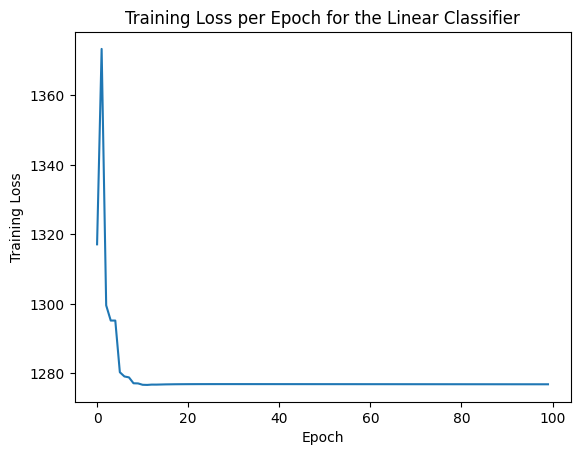

In [67]:
plt.plot(training_losses_linear_classifier_new)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for the Linear Classifier')
plt.show()

In [68]:
test_dataset_linear_classifier_new = LinearClassifierDataset(image_embeddings_trained[7000:], texts_labels_int[7000:])
test_dataloader_linear_classifier_new = DataLoader(test_dataset_linear_classifier_new, batch_size=batch_size)

In [69]:
linear_classifier_two.eval()

outputs_list = []
labels_list = []
total_loss = 0

with torch.no_grad():
    for batch in test_dataloader_linear_classifier_new:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
    
        outputs = linear_classifier_two(images)
        outputs_list.append(outputs)
        labels_list.append(labels)
    
        batch_loss = criterion(outputs, labels)
        total_loss += batch_loss.detach().cpu().item()

print(total_loss)
print(len(outputs_list))

1.823900083763874e-05
9


In [70]:
outputs_all = torch.cat(outputs_list, dim=0)
labels_all = torch.cat(labels_list, dim=0)
outputs_all = outputs_all.detach().cpu().numpy()
labels_all = labels_all.detach().cpu().numpy()
print(outputs_all.shape)
print(labels_all.shape)

(180, 9)
(180,)


In [71]:
predicted_labels = np.argmax(outputs_all, axis=1) # row-wise argmax 
print(predicted_labels.shape)
f1 = f1_score(labels_all, predicted_labels, average="weighted")
print(f1)

(180,)
1.0
